# Topic modeling on abstracts

## 1. Preprocessing

In [1]:
import pandas as pd
import os 
import numpy as np
import re
import random

In [2]:
import nltk
from nltk import word_tokenize, RegexpTokenizer,PunktSentenceTokenizer, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#nltk.download('stopwords')

In [3]:
#!pip install gensim

In [4]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

### 1.1 Load the data 

In [16]:
#abstracts = pd.read_csv("abstracts.csv")
abstracts = pd.read_csv("abstracts_eng.csv")

In [17]:
abstracts.head()

,abstract,id
0,The goal of this note is to introduce new clas...,188444.0
1,We will review a Lemma published by Ran Raz in...,188623.0
2,China’s growing influence in Europe has the po...,346708.0
3,Nowhere is China's Belt and Road Initiative (B...,346709.0
4,Passenger transit modes typical of the urban s...,187461.0


In [18]:
abs_list = list(abstracts['abstract'])

In [19]:
len(abs_list)

20494

**21421** abstracts in total  
**20494** abstracts in english

### 1.2 Step 1 
- tokenization 
- punctuation removal 
- lowercasing

In [20]:
tokenised = []
count = 0
for abstract in abs_list:
    raw = abstract
    tokens = gensim.utils.simple_preprocess(str(raw), deacc=True)
    tokenised.append(tokens)
    count += len(tokens)
print(str(count)+" tokens created")

3855522 tokens created


In [21]:
c = []
for doc in tokenised: 
    c+=doc
len(set(c))

71429

So we have **83831** / **71429** (de/en) unique words in the beginning

### 1.3 Step 2 
- removing stopwords 
- (removing other words based on different strategies - like word length thresholding) 

In [22]:
stop_words = stopwords.words('english')
cleaned = [[word for word in doc if word not in stop_words] for doc in tokenised]

In [23]:
# Consider extending the stopwords ...
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [24]:
# Consider removing words with less than [x] characters 

In [25]:
c = []
for doc in cleaned: 
    c+=doc
len(set(c))

71293

Now after stopwords removal we have **83695** / **71293** terms (136 less)

### 1.4 Step 3 
- stemming 
- lemmatizing 

In [26]:
#nltk.download('wordnet')

In [27]:
word_stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()
lemmatized = [[lemmatiser.lemmatize(word_stemmer.stem(word)) for word in doc] for doc in cleaned]

In [28]:
c = []
for doc in lemmatized: 
    c+=doc
len(set(c))

50948

And after stemming and lemmatization we have **61182** / **50948** terms (22,513 less)

Maybe we could also lemmatise keeping only noun, adjective, verb, adverb

data_lemmatized = lemmatization(bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [29]:
abstract_clean[23]

NameError: name 'abstract_clean' is not defined

### 1.5 Build n-grams

This seems to be done before lemmatization and stemming in a lot of tutorials

In [ ]:
# n-grams creation hyperparameters 
# leaving here the hyperparameters so that we can tune them properly
# min_count (float, optional) – Ignore all words and bigrams with total collected count lower than this value.
b_min_c = 5 
t_min_c = 5
# threshold (float, optional) – Represent a score threshold for forming the phrases (higher means fewer phrases)
b_thre = 50
t_thre = 5
# scoring ({'default', 'npmi', function}, optional) –Specify how potential phrases are scored
# for now we go with default storing

In [ ]:
bigram = gensim.models.Phrases(lemmatized, min_count=b_min_c, threshold=b_thre) 
bigram_mod = gensim.models.phrases.Phraser(bigram)


Two interesting results from the bigram model : 

In [ ]:
# Case 1: no change --> no bigrams found 
lemmatized[0]==bigram_mod[lemmatized[0]]

In [ ]:
# Case 2: some change but we actually lose vocabulary ...
len(bigram_mod[lemmatized[110]])-len(lemmatized[110])

In [ ]:
# MOREOVER, we have german words inside!!
print(bigram_mod[lemmatized[110]]) 

In [ ]:
trigram = gensim.models.Phrases(bigram[lemmatized], min_count=t_min_c, threshold=t_thre)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# Take a look at some of the trigrams
print(trigram_mod[lemmatized[31]])

In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
c

In [ ]:
c = []
for doc in bigrammed: 
    c+=doc
len(set(c))

**5470** bigrams

In [ ]:
c = []
for doc in trigrammed: 
    c+=doc
len(set(c))

**12894** trigrams

After grouping words that occur commonly together we have 69312 / **69312** terms (17,741 more)

### 1.6 Analyse the vocabulary

In [ ]:
cleaned = trigrammed

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
wordlist = flatten(cleaned)

In [ ]:
from collections import Counter
counts = Counter(wordlist)

In [ ]:
counts.most_common(20)

In [20]:
hist(counts.most_common(10))

## 2. Modelling

## 2.1 LDA

In [ ]:
#!pip3.7 install tomotopy

In [7]:
import sys
import tomotopy as tp

### 2.1.1 Training example

----


In [32]:
# Defining hyperparameters
tw = tp.TermWeight.ONE # term weighting scheme in TermWeight. The default value is TermWeight.ONE
k = 150 # number of topics...
min_cf=3 # minimum collection frequency of words. Words with a smaller collection frequency than min_cf are excluded from the model. The default value is 0, which means no words are excluded.
min_df=0 # minimum document frequency of words. Words with a smaller document frequency than min_df are excluded from the model. The default value is 0, which means no words are excluded
rm_top=5 # the number of top words to be removed. If you want to remove too common words from model, you can set this value to 1 or more. The default value is 0, which means no top words are removed.
alpha = None # hyperparameter of Dirichlet distribution for document-topic
eta = None # hyperparameter of Dirichlet distribution for topic-word
seed = 41 # random seed
model_burn_in = 100 
train_updates = 1000
train_iter = 10
save_path = "lda_model150.bin" #.bin format

In [34]:
# Instantiating the model
model = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=k)

In [35]:
# adding documents to the model 
for doc in cleaned: model.add_doc(doc)

In [36]:
# training**
model.burn_in = model_burn_in
# initialising 
model.train(iter=0)
print('Num docs:', len(model.docs), ', Vocab size:', len(model.used_vocabs), ', Num words:', model.num_words)
print('Removed top words:', model.removed_top_words)
print('Training...', file=sys.stderr, flush=True)
# actual training 
time = []
LLs = []
for i in range(0, train_updates, train_iter):
    model.train(train_iter)
    if i%100==0:print('Iteration: {}'.format(i))
    time.append(i)
    LLs.append(model.ll_per_word)

Training...


Num docs: 20494 , Vocab size: 42219 , Num words: 2045097
Removed top words: ['use', 'model', 'result', 'studi', 'base']
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Iteration')

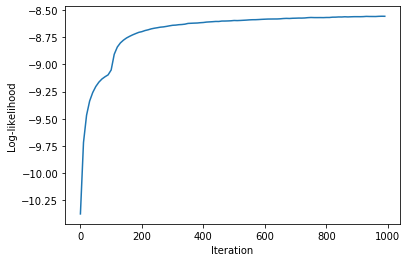

In [37]:
plt.plot(time,LLs)
plt.ylabel('Log-likelihood')
plt.xlabel('Iteration')

In [59]:
#loading a model
model1000 = tp.LDAModel.load("./lda1000.bin")

In [61]:
model = tp.LDAModel.load("./lda_model150.bin")

In [60]:
model1000.summary()

<Basic Info>
| LDAModel (current version: 0.9.1)
| 12296 docs, 1282721 words
| Total Vocabs: 56507, Used Vocabs: 56507
| Entropy of words: -8.71197
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 500, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -8.81762
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 1000 (the number of topics between 1 ~ 32767)
| alpha: 0.1 (hyperparameter of Dirichlet distribution for document-topic)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 1545481725 (random seed)
| trained in version 0.9.1
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [9.35984426e-05 5.93639503e-04 4.68380895e-04 7.04644388e-03
|   4.99611895e-04 1.24803584e-04 2.57593412e-02 1.20428018e-03
|   7.11180363e-03 7.34896306e-03 9.99999975e-

| #51 (2549) : model mass search event momentum
| #52 (1693) : imag uptak tb kidney pet
| #53 (299) : effici persist ked transient compani
| #54 (991) : postur angl posit marker segment
| #55 (544) : migrat immigr migrant skill migratori
| #56 (956) : leaf canopi leav transpir plant
| #57 (494) : th polyploid meiotic crossov diploid
| #58 (99) : descriptor burn ash jatropha_curca prw
| #59 (201) : metric standard technolog_aid metrolog avian
| #60 (16844) : data use inform analysi sampl
| #61 (1688) : forecast indic predict real_time period
| #62 (393) : ec n_ oc carbonac_aerosol elf
| #63 (197) : histon chromatin ptm cac nucleosom
| #64 (757) : growth grow growth_rate situ hypocotyl
| #65 (88) : sirna trna p orn fragment
| #66 (61) : salari doctor_student erdw rdt soe
| #67 (154) : trade flow versu telecoupl negoti
| #68 (1236) : neuromorph neural learn spike brain
| #69 (707) : mr gaba magnitud glutam brain
| #70 (4499) : imag camera accuraci sensor point
| #71 (276) : lat amino_acid

| #278 (44) : o_ ppp south_africa pas remain_rel
| #279 (60) : narr local_scale silicen restor forest_restor
| #280 (708) : mutant defect mutat cell_wall tsc
| #281 (2296) : pathogen isol fungal resist infect
| #282 (1615) : network wireless commun protocol deploy
| #283 (3743) : flow fluid veloc viscos transport
| #284 (237) : peptid adp_ribosyl kdac self_assembl_peptid_hydrogel kat
| #285 (102) : redistribut critic_task demand mix_critic task_overrun
| #286 (36) : eccdna pigeon breast nucleu repetit_element
| #287 (132) : matroid pea diffus_light gcm pep
| #288 (443) : tunnel face ground stabil reinforc
| #289 (64) : na glyr io satellit anion
| #290 (302) : medium born phenomenon complementari admitt
| #291 (14) : meat_altern previou_find escalop model result
| #292 (204) : mdr pgp gelatin lta galactos
| #293 (118) : lg snowb_speci pizzo_mondello newark norian
| #294 (3768) : compound reaction synthesi acid format
| #295 (227) : imf condition world_bank loan countri
| #296 (501) : al

| #496 (371) : neg quarter compani news mutual
| #497 (0) : use model result studi base
| #498 (48) : nanoplatelet inductor babi downhol fea
| #499 (276) : db stn stimul tremor deep_brain
| #500 (196) : loss gan core inductor power_densiti
| #501 (3761) : softwar tool packag user pipelin
| #502 (144) : suicid om appar rdp degrad
| #503 (844) : ligand complex coordin bond nmr
| #504 (129) : apo cobinamid spo pwv sdb
| #505 (50) : ad ad_icc_ci lexa orthogon er
| #506 (284) : free_energi transit_state metadynam molecular_dynam atomist
| #507 (248) : islet insulin lim diabet vapor_pressur
| #508 (450) : resourc manag sustain regul intervent
| #509 (300) : arc current disconnector voltag ocean_plateau
| #510 (67) : lnk chico sh inr adaptor
| #511 (187) : vet hoxb educ vpa satisfact
| #512 (213) : bubbl foam pulsat burst coalesc
| #513 (34) : sio silanol_content butanol gigapasc stiffer
| #514 (43) : effort dlpfc exert fatigu endur
| #515 (91) : coil_coil sclerit lz retro zipper
| #516 (570)

| #714 (144) : sox replic pole xx cnvr
| #715 (284) : associ cardiac midkin smoke ream
| #716 (3408) : melt crystal composit rock magma
| #717 (154) : vulgari oad oxomalon microalga biomass
| #718 (990) : cooper competit social exploit natur
| #719 (798) : cow milk bell dairi_cow farmer
| #720 (227) : light dark vortex_tube photosynthesi disrupt
| #721 (652) : de la et le une
| #722 (3382) : detector experi beam neutrino energi
| #723 (154) : lesion tp mountain chlorothalonil high_altitud
| #724 (168) : mainten util underground reliabl underground_util
| #725 (31) : roa nullspac pc_expans individu_claim shuttl
| #726 (0) : use model result studi base
| #727 (614) : iodin iodin_defici pe pregnant_woman pregnanc
| #728 (187) : rank eo primari mutual_exclus coup
| #729 (609) : adsorb adsorpt adsorpt_chiller mof dynam
| #730 (127) : harvest wearabl acquisit_setup semg biopotenti
| #731 (880) : polici commit target implement support
| #732 (767) : consum consumpt food product meat
| #733 (1

| #901 (31) : clone llnicad ir nicad syntact
| #902 (112) : techniqu graft tech_group loop doubl
| #903 (1052) : trait phenotyp organ reproduct growth
| #904 (35) : cap sex_hormon mcc pneumonia rho
| #905 (0) : use model result studi base
| #906 (8231) : countri price effect polici econom
| #907 (239) : methanol mcmc crfr pnipam methanol_emiss
| #908 (1038) : conserv biodivers threat protect_area collis
| #909 (154) : miner cave mineralog speleothem mushroom
| #910 (105) : hbm tmp cn penetr disrupt_scenario
| #911 (834) : satellit orbit gp mission gnss
| #912 (10) : poncelet nonisomorph near_field pascal miniquaternion
| #913 (365) : pressur high_pressur mpa kbar minimum
| #914 (1097) : walk gait walk_speed paramet pedestrian
| #915 (85) : fit amrz brace filament_phage denv
| #916 (1982) : forest tree manag tree_speci log
| #917 (296) : mortal surviv sever dvm die
| #918 (3700) : network vehicl traffic travel_time car
| #919 (571) : game player equilibrium price_anarchi nash_equilibriu

In [39]:
model.summary()

<Basic Info>
| LDAModel (current version: 0.9.1)
| 20494 docs, 2045097 words
| Total Vocabs: 69312, Used Vocabs: 42219
| Entropy of words: -8.71136
| Removed Vocabs: use model result studi base
|
<Training Info>
| Iterations: 1000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -8.55467
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 150 (the number of topics between 1 ~ 32767)
| alpha: 0.1 (hyperparameter of Dirichlet distribution for document-topic)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 2701034930 (random seed)
| trained in version 0.9.1
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.01444488 0.01288824 0.00593498 0.00734891 0.00831222 0.00687317
|   0.01133983 0.01438276 0.00715053 0.01548557 0.00768358 0.01446925
|   0.02497

In [38]:
print('Saving...', file=sys.stderr, flush=True)
model.save(save_path, full=True) # If full is True, the model with its all documents and state will be saved. If you want to train more after, use full model. If False, only topic parameters of the model will be saved. This model can be only used for inference of an unseen document.

Saving...


Let's have a better look at the results!

In [126]:
for k in range(model.k):
    print('Topic #{}'.format(k))
    for word, prob in model.get_topic_words(k):
        print('\t', word, prob, sep='\t')

Topic #0
		survey	0.013973632827401161
		activ	0.012106232345104218
		data	0.011494496837258339
		particip	0.009594899602234364
		choic	0.009111951105296612
		time	0.008822182193398476
		person	0.007405532523989677
		household	0.007180156651884317
		behavior	0.007147959899157286
		estim	0.007147959899157286
Topic #1
		countri	0.01404231321066618
		polici	0.012152024544775486
		effect	0.011071859858930111
		firm	0.008573978208005428
		product	0.008523344993591309
		find	0.008287059143185616
		market	0.007881997153162956
		price	0.007240649312734604
		econom	0.006886220537126064
		increa	0.006126729305833578
Topic #2
		reaction	0.008497463539242744
		oxid	0.00690773269161582
		activ	0.006767048500478268
		water	0.005782259628176689
		surfac	0.0055853016674518585
		format	0.005543096456676722
		chemic	0.005332070402801037
		concentr	0.005303933285176754
		co	0.005135112442076206
		process	0.00483967550098896
Topic #3
		system	0.01928514428436756
		optim	0.016986647620797157
		energi	0.015

### 2.1.2 Hyperparameter tuning by optimizing log-likelihood  

---

Note: log-likelihood is generally not considered a good measure for topic model performance...

In [27]:
def train_LDA(documents, k, min_cf=0, min_df=0, rm_top=0, alpha=0.1, eta=0.01, model_burn_in=100, 
              train_updates = 1000, train_iter = 10):
    
    # instantiate
    model = tp.LDAModel(tw=tp.TermWeight.ONE, min_df=min_df, min_cf=min_cf, rm_top=rm_top, k=k, alpha = alpha, 
                        eta = eta)
    
    # add documents to model
    for doc in documents: model.add_doc(doc)
    
    # training**
    model.burn_in = model_burn_in
    # initialising 
    model.train(iter=0)
    print('Num docs:', len(model.docs), ', Vocab size:', len(model.used_vocabs), ', Num words:', model.num_words)
    print('Removed top words:', model.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    # actual training 
    time = []
    LLs = []
    for i in range(0, train_updates, train_iter):
        model.train(train_iter)
        if i%100==0:print('Iteration: {}'.format(i))
        time.append(i)
        LLs.append(model.ll_per_word)
    
    return model, LLs, time

In [39]:
# simple loop for minimizing perplexity on the training set

topics = [10,20,30]
perplexity_score = np.array([])
for k in topics:
    print("Training for "+str(k)+" topics")
    model, LLs, time = train_LDA(cleaned, k = k, train_updates = 600)
    perplexity_score = np.append(perplexity_score, model.perplexity)
    print("Perplexity = "+str(model.perplexity))

topics[np.argmin(perplexity_score)]

Training...


Num docs: 20494 , Vocab size: 69312 , Num words: 2141113
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500


Training...


Num docs: 20494 , Vocab size: 69312 , Num words: 2141113
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500


Training...


Num docs: 20494 , Vocab size: 69312 , Num words: 2141113
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500


30

Text(0.5, 0, 'Number of topics')

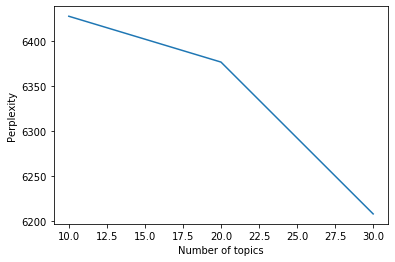

In [42]:
plt.plot(topics,perplexity_score)
plt.ylabel('Perplexity')
plt.xlabel('Number of topics')

In [168]:
# split data in train and test set

print(len(cleaned))
train_size = int(0.8*len(cleaned))

random.shuffle(cleaned)
train_docs = cleaned[0:train_size]
test_docs = cleaned[train_size:]

assert len(train_docs) + len(test_docs) == len(cleaned)

20494


In [30]:
def get_test_LL(test_docs, model):
    
    # make a list of documents of type required by tp
    test_set = []
    for doc in test_docs:
        test_set.append(model.make_doc(doc))
    
    # return topic distribution and log-likelihood of new documents
    topic_dist, likelihood = model.infer(test_set)
    
    # use mean log-likelihood as performance measure
    return np.mean(likelihood)

In [172]:
# loop for maximizing mean likelihood of test set

topics = [10,20,30]
log_likelihoods = np.array([])
for k in topics:
    print("Training for "+str(k)+" topics")
    model, LLs, time = train_LDA(train_docs, k = k, train_updates = 800)
    log_likelihoods = np.append(log_likelihoods, get_test_LL(test_docs, model))
    print("Log likelihood = "+str(get_test_LL(test_docs, model)))

topics[np.argmax(log_likelihoods)]

Training...


Num docs: 16395 , Vocab size: 62919 , Num words: 1713454
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700


Training...


Num docs: 16395 , Vocab size: 62919 , Num words: 1713454
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700


Training...


Num docs: 16395 , Vocab size: 62919 , Num words: 1713454
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700


30

In [ ]:
plt.plot(topics,log_likelihoods)
plt.ylabel('Likelihood')
plt.xlabel('Number of topics')

In [173]:
print(likelihoods)

[-882.05810779 -882.89588814 -879.71187388]


### 2.1.3 Topic coherence 

---

Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

In [58]:
num_topics = 10

In [59]:
extract_word = lambda x: x[0] # get_topic_words returns both the word and its probability in the topic
topics = [[extract_word(tw) for tw in model.get_topic_words(k, 20)] for k in range(1,num_topics)]

Exception: must topic_id < K

In [59]:
topics[0]

['infect',
 'strain',
 'bacteria',
 'host',
 'resist',
 'bacteri',
 'pathogen',
 'cell',
 'use',
 'viru',
 'vaccin',
 'isol',
 'antibiot',
 'product',
 'iron',
 'viral',
 'microbiota',
 'specif',
 'diseas',
 'phage']

In [28]:
from gensim.corpora import Dictionary

In [39]:
dictionary = Dictionary(cleaned)
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in cleaned] # bag of words corpus 

In [66]:
BoW_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 2),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1)]

In [50]:
# saving the coherence preprocessing operations into two functions
extract_word = lambda x: x[0] # get_topic_words returns both the word and its probability in the topic

def get_topics(model, num_topics):
    return [[extract_word(tw) for tw in model.get_topic_words(k, 20)] for k in range(num_topics)]

def get_corpus(dictionary, texts):
    return [dictionary.doc2bow(doc, allow_update=True) for doc in texts]

In [70]:
# topics (list of list of str, optional) – List of tokenized topics
# texts (list of list of str, optional) – Tokenized texts, needed for coherence models that use sliding window based (i.e. coherence=`c_something`) probability estimator .
# corpus (iterable of list of (int, number), optional) – Corpus in BoW format.
# dictionary (Dictionary, optional) – Gensim dictionary mapping of id word to create corpus. If model.id2word is present, this is not needed. If both are provided, passed dictionary will be used.
# window_size (int, optional) – Is the size of the window to be used for coherence measures using boolean sliding window as their probability estimator. For ‘u_mass’ this doesn’t matter. If None - the default window sizes are used which are: ‘c_v’ - 110, ‘c_uci’ - 10, ‘c_npmi’ - 10.
# coherence ({'u_mass', 'c_v', 'c_uci', 'c_npmi'}, optional) – Coherence measure to be used. Fastest method - ‘u_mass’, ‘c_uci’ also known as c_pmi. For ‘u_mass’ corpus should be provided, if texts is provided, it will be converted to corpus using the dictionary. For ‘c_v’, ‘c_uci’ and ‘c_npmi’ texts should be provided (corpus isn’t needed)
# topn (int, optional) – Integer corresponding to the number of top words to be extracted from each topic.
cm = CoherenceModel(topics=topics, corpus=BoW_corpus, dictionary=dictionary, texts=cleaned, coherence='c_v')
coherence = cm.get_coherence()  # get coherence value
coherence

0.49646788489478966

In [ ]:
# Note: there are different types of coherence measures, we need to decide which to use!

###  2.1.4 Complete grid search 

---

In [18]:
random.seed = 11

In [20]:
# split data in train, test and validation set
print(len(cleaned))
train_size = int(0.7*len(cleaned)) #70% for training
test_size = int(0.3*len(cleaned)) #30% for testing 

random.shuffle(cleaned)

train_docs = cleaned[0:train_size]
test_docs = cleaned[train_size:]

len(train_docs) + len(test_docs) == len(cleaned)

20494


True

In [21]:
# Defining the grid

ks = [50, 100, 150, 200, 300, 350, 450]
#alpha = [1/k, 10/k, 0.1/k, None]
#eta = [1/w, 10/w, 0.1/w, None]

In [33]:
def compute_test_pp(ll, docs):
    """ pp = exp(-ll/ct)"""
    ct = sum([len(docs) for doc in docs])
    pp = np.exp(-1*ll/ct)
    return pp

In [29]:
# Grid search of best topic number (this needs to run for a while)
# We collect LL, perplexity and coherence scores, saving them in variables 

import time

pps = []
best_models = []
# number of words in our vocabulary
c = []
for doc in train_docs: 
    c+=doc
w = len(set(c))

# define training parameters 
model_burn_in=250
train_updates = 1000
train_iter = 10

for k in ks:
    
    start = time.time()

    for alpha in [1/k, 10/k, 0.1/k, None]:      
        for eta in [1/w, 10/w, 0.1/w, None]:
    
            print("K= "+str(k)+", alpha = "+str(alpha)+", eta="+str(eta)+" -----------------------------")
            model, LLs, _ = train_LDA(train_docs, k, 
                                      alpha=alpha,
                                      eta=eta, 
                                      model_burn_in=model_burn_in,
                                      train_updates = train_updates, 
                                      train_iter = train_iter)

            # LL
            ll = get_test_LL(test_docs, model)
            ## PP
            # TODO: obtain perplexity on the test set
            pp = compute_test_pp(ll, test_docs)
            pps += [pp]
            print("Test perplexity = "+str(pp))

            
            end = time.time()

            print("Time elapsed: "+ str(round(end - start,1))+" s")

K= 50, alpha = 0.02, eta=1.671541997492687e-05 -----------------------------


Training...


Num docs: 14345 , Vocab size: 59825 , Num words: 1740123
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900


NameError: name 'get_test_LL' is not defined

Text(0.5, 1.0, 'Train coherence')

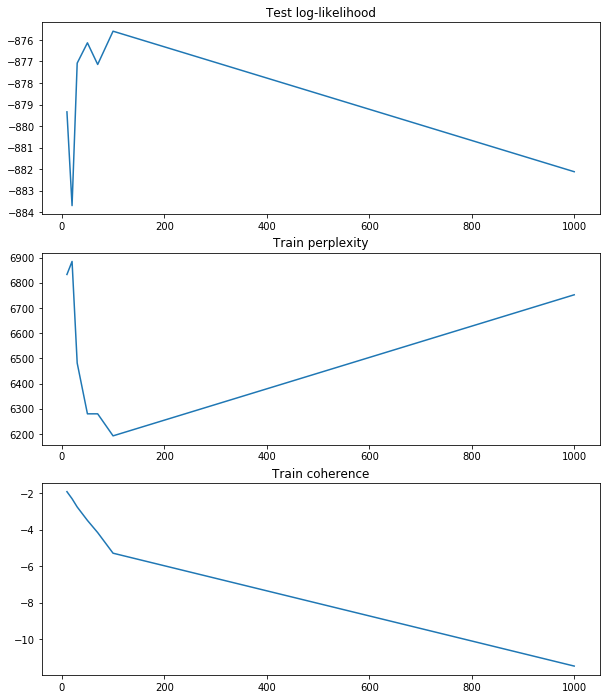

In [51]:
# plotting the results
fig, axs = plt.subplots(3, 1, figsize=(10,12))
axs[0].plot(ks,log_likelihoods)
axs[1].plot(ks,perplexities)
axs[2].plot(ks,coherences)
axs[0].set_title("Test log-likelihood")
axs[1].set_title("Train perplexity")
axs[2].set_title("Train coherence")

In [ ]:
# savin big model 
model.save("lda1000.bin", full=True)

In [ ]:
# Looking at the biggest model a bit

In [64]:
topics = get_topics(model, k)
corpus = get_corpus(dictionary, train_docs)
cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, texts=train_docs, coherence='c_v')
cm.get_coherence()

0.400896904940071

In [66]:
for k in range(10,20):
    print('Topic #{}'.format(k))
    for word, prob in model.get_topic_words(k):
        print('\t', word, prob, sep='\t')

Topic #10
		use	1.7696922441245988e-05
		model	1.7696922441245988e-05
		result	1.7696922441245988e-05
		studi	1.7696922441245988e-05
		base	1.7696922441245988e-05
		differ	1.7696922441245988e-05
		measur	1.7696922441245988e-05
		data	1.7696922441245988e-05
		system	1.7696922441245988e-05
		effect	1.7696922441245988e-05
Topic #11
		architectur	0.06618456542491913
		concept	0.016145627945661545
		architect	0.015338548459112644
		design	0.01049607153981924
		histori	0.01049607153981924
		form	0.01049607153981924
		american	0.01049607153981924
		understand	0.010092531330883503
		citi	0.00968899205327034
		notion	0.009285451844334602
Topic #12
		mobil	0.14631308615207672
		plateau	0.024203117936849594
		human_mobil	0.011531327851116657
		continuum	0.0046194433234632015
		electron_gase	0.0046194433234632015
		key_factor	0.003467462258413434
		supersolid	0.003467462258413434
		tmb	0.003467462258413434
		implicitli	0.00231548142619431
		frozen	0.00231548142619431
Topic #13
		mpl	0.017271336168

In [ ]:
# TODO: evaluate the model on the validation set 

In [ ]:
get_test_coherence(model, test_docs, dictionary):
    """ Get topics over test set and compute coherence"""
    pass

#### Nice visualisation 

--- 

In [36]:
#!pip3.7 install pyLDAvis

In [42]:
import pyLDAvis
pyLDAvis.enable_notebook()

**Note**: you need to have trained a model to use the following code 

In [43]:
topic_term_dists = np.stack([model.get_topic_word_dist(k) for k in range(model.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in model.docs])
doc_lengths = np.array([len(doc.words) for doc in model.docs])
vocab = list(model.used_vocabs)
term_frequency = model.used_vocab_freq

In [44]:
# doesn't work ...
doc = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency)

c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## 2.2 CTM

### 2.2.1 Training example

In [88]:
# Define the hyperparameters
tw = tp.TermWeight.ONE # term weighting scheme in TermWeight. The default value is TermWeight.ONE
k = 5 # number of topics
min_cf=3 # minimum collection frequency of words. Words with a smaller collection frequency than min_cf are excluded from the model. The default value is 0, which means no words are excluded.
rm_top=5 # the number of top words to be removed. If you want to remove too common words from model, you can set this value to 1 or more. The default value is 0, which means no top words are removed.
alpha = None # hyperparameter of Dirichlet distribution for document-topic
eta = None # hyperparameter of Dirichlet distribution for topic-word
seed = 41 # random seed
model_burn_in = 100 
train_updates = 500
train_iter = 10
save_path = "ctm_model.bin" #.bin format

In [40]:
def train_CTM(documents, k, min_cf=0, rm_top=0, smoothing_alpha=0.1, eta=0.01, model_burn_in=100, 
              train_updates = 1000, train_iter = 10):
    
    # instantiate
    model = tp.CTModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=k, smoothing_alpha = smoothing_alpha,
                      eta = eta)
    
    # add documents to model
    for doc in documents: model.add_doc(doc)
    
    # training**
    model.burn_in = model_burn_in
    # initialising 
    model.train(iter=0)
    print('Num docs:', len(model.docs), ', Vocab size:', len(model.used_vocabs), ', Num words:', model.num_words)
    print('Removed top words:', model.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    # actual training 
    time = []
    LLs = []
    for i in range(0, train_updates, train_iter):
        model.train(train_iter)
        if i%100==0:print('Iteration: {}'.format(i))
        time.append(i)
        LLs.append(model.ll_per_word)
    
    return model, LLs, time

In [92]:
import time
start = time.time()
model, LLs, _ = train_CTM(cleaned, k=k, min_cf=min_cf, rm_top=rm_top, smoothing_alpha=alpha, 
                                 eta=eta, model_burn_in=model_burn_in, 
                                 train_updates = train_updates, train_iter = train_iter)
end = time.time()
print("Time elapsed: "+ str(round(end - start,1))+" s")

Training...


Num docs: 20494 , Vocab size: 42219 , Num words: 2045097
Removed top words: ['use', 'model', 'result', 'studi', 'base']
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Time elapsed: 154.8 s


In [95]:
# compare time to LDA with same hyperparameters

start = time.time()
train_LDA(cleaned, k=k, min_cf=min_cf, rm_top=rm_top, alpha=alpha, 
                                 eta=eta, model_burn_in=model_burn_in, 
                                 train_updates = train_updates, train_iter = train_iter)
end = time.time()
print("Time elapsed: "+ str(round(end - start,1))+" s")

Training...


Num docs: 20494 , Vocab size: 42219 , Num words: 2045097
Removed top words: ['use', 'model', 'result', 'studi', 'base']
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Time elapsed: 13.7 s


In [48]:
for k in range(model.k):
    print('Topic #{}'.format(k))
    for word, prob in model.get_topic_words(k):
        print('\t', word, prob, sep='\t')

Topic #0
		model	0.02911013923585415
		process	0.008280729874968529
		one	0.008222708478569984
		dynam	0.007234036922454834
		system	0.006990350317209959
		sampl	0.006723455153405666
		measur	0.0062407236546278
		result	0.006233761087059975
		appli	0.005887958221137524
		paramet	0.005788162816315889
Topic #1
		use	0.012448491528630257
		perform	0.012123850174248219
		structur	0.011803880333900452
		function	0.010138634592294693
		data	0.00976494699716568
		also	0.00917171873152256
		method	0.009150698781013489
		base	0.008919479325413704
		measur	0.00791752990335226
		gener	0.007546177599579096
Topic #2
		use	0.022704770788550377
		show	0.00995029229670763
		control	0.00987785030156374
		studi	0.008840292692184448
		design	0.008013051003217697
		test	0.007232546340674162
		experi	0.007017557043582201
		data	0.0066530099138617516
		approach	0.0066389888525009155
		product	0.006552525795996189
Topic #3
		studi	0.012134483084082603
		increas	0.011137831956148148
		chang	0.0107652526348829

In [50]:
# Look at topic correlations
model.get_correlations()

array([[ 1.        ,  0.22246677,  0.11326577, -0.01405197,  0.13137358],
       [ 0.22246677,  1.        ,  0.15056095, -0.00279401,  0.13987428],
       [ 0.11326577,  0.15056095,  1.        ,  0.18342696,  0.15434065],
       [-0.01405197, -0.00279401,  0.18342696,  1.        ,  0.15774994],
       [ 0.13137358,  0.13987428,  0.15434065,  0.15774994,  1.        ]],
      dtype=float32)

In [ ]:
#!pip3.7 install pyvis

In [57]:
# visualization tool for topic correlations

from pyvis.network import Network

g = Network(width=800, height=800, font_color="#333")
correl = model.get_correlations().reshape([-1])
correl.sort()
top_tenth = model.k * (model.k - 1) // 10
top_tenth = correl[-model.k - top_tenth]

for k in range(model.k):
    label = "#{}".format(k)
    title= ' '.join(word for word, _ in model.get_topic_words(k, top_n=6))
    print('Topic', label, title)
    g.add_node(k, label=label, title=title, shape='ellipse')
    for l, correlation in zip(range(k - 1), model.get_correlations(k)):
        if correlation < top_tenth: continue
        g.add_edge(k, l, value=float(correlation), title='{:.02}'.format(correlation))

g.barnes_hut(gravity=-1000, spring_length=20)
g.show_buttons()
g.show("topic_network.html")

Topic #0 model process one dynam system sampl
Topic #1 use perform structur function data also
Topic #2 use show control studi design test
Topic #3 studi increas chang develop high combin
Topic #4 differ effect cell base compar predict


### 2.2.2 Complete grid search

In [45]:
# helper functions 

def get_test_LL(test_docs, model):
    
    # make a list of documents of type required by tp
    test_set = []
    for doc in test_docs:
        test_set.append(model.make_doc(doc))
    
    # return topic distribution and log-likelihood of new documents
    topic_dist, likelihood = model.infer(test_set)
    
    # use mean log-likelihood as performance measure
    return np.mean(likelihood)

def compute_test_pp(ll, docs):
    """ pp = exp(-ll/ct)"""
    ct = sum([len(docs) for doc in docs])
    pp = np.exp(-1*ll/ct)
    return pp

In [30]:
random.seed = 11

In [31]:
# split data in train, test and validation set
print(len(cleaned))
train_size = int(0.7*len(cleaned)) #70% for training
test_size = int(0.3*len(cleaned)) #30% for testing 

random.shuffle(cleaned)

train_docs = cleaned[0:train_size]
test_docs = cleaned[train_size:]

len(train_docs) + len(test_docs) == len(cleaned)

20494


True

In [41]:
# Defining the grid

c = []
for doc in train_docs: 
    c+=doc
w = len(set(c))

ks = [50, 100, 150, 200, 300, 350, 450]
etas = [1/w, 10/w, 0.1/w, None]

In [46]:
# Grid search of best topic number (this needs to run for a while)
# We collect LL, perplexity and coherence scores, saving them in variables 

import time

pps = []
best_models = []
# number of words in our vocabulary

# define training parameters 
model_burn_in=250
train_updates = 1000
train_iter = 10

for k in ks:
    
    start = time.time()
      
    for eta in etas:

        print("K= "+str(k)+", eta="+str(eta)+" -----------------------------")
        model, LLs, _ = train_CTM(train_docs, k,
                                  eta=eta, 
                                  model_burn_in=model_burn_in,
                                  train_updates = train_updates, 
                                  train_iter = train_iter)

        # LL
        ll = get_test_LL(test_docs, model)
        ## PP
        pp = compute_test_pp(ll, test_docs)
        pps += [pp]
        print("Test perplexity = "+str(pp))


        end = time.time()

        print("Time elapsed: "+ str(round(end - start,1))+" s")

K= 1, eta=1.67484549550304e-05 -----------------------------


Training...


Num docs: 14345 , Vocab size: 59707 , Num words: 1736816
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Test perplexity = 1.0000326501379062
Time elapsed: 67.5 s
K= 1, eta=0.000167484549550304 -----------------------------


Training...


Num docs: 14345 , Vocab size: 59707 , Num words: 1736816
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200


KeyboardInterrupt: 

## 2.3 Pachinko

### 2.3.1 Training example

In [96]:
# Hyperparameters
tw = tp.TermWeight.ONE # term weighting scheme in TermWeight. The default value is TermWeight.ONE
k1 = 1 # the number of super topics 
k2 = 5 # the number of sub topics
min_cf=3 # minimum collection frequency of words. Words with a smaller collection frequency than min_cf are excluded from the model. The default value is 0, which means no words are excluded.
rm_top=5 # the number of top words to be removed. If you want to remove too common words from model, you can set this value to 1 or more. The default value is 0, which means no top words are removed.
alpha = None # hyperparameter of Dirichlet distribution for document-topic
eta = None # hyperparameter of Dirichlet distribution for topic-word
seed = 41 # random seed
model_burn_in = 100 
train_updates = 500
train_iter = 10
save_path = "pachinko_model.bin" #.bin format

In [ ]:
# Note: only possible to have two layers in topic tree??

In [53]:
def train_PA(documents, k1, k2, min_cf=0, rm_top=0, alpha=0.1, eta=0.01, model_burn_in=100, 
              train_updates = 1000, train_iter = 10):
    
    # instantiate
    model = tp.PAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k1=k1, k2=k2, alpha = alpha, eta = eta)
    
    # add documents to model
    for doc in documents: model.add_doc(doc)
    
    # training**
    model.burn_in = model_burn_in
    # initialising 
    model.train(iter=0)
    print('Num docs:', len(model.docs), ', Vocab size:', len(model.used_vocabs), ', Num words:', model.num_words)
    print('Removed top words:', model.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    # actual training 
    time = []
    LLs = []
    for i in range(0, train_updates, train_iter):
        model.train(train_iter)
        if i%100==0:print('Iteration: {}'.format(i))
        time.append(i)
        LLs.append(model.ll_per_word)
    
    return model, LLs, time

In [98]:
import time
start = time.time()
model, LLs, iters = train_PA(cleaned, k1=k1, k2=k2, min_cf=min_cf, rm_top=rm_top, alpha=alpha, 
                                 eta=eta, model_burn_in=model_burn_in, 
                                 train_updates = train_updates, train_iter = train_iter)
end = time.time()
print("Time elapsed: "+ str(round(end - start,1))+" s")

Training...


Num docs: 20494 , Vocab size: 42219 , Num words: 2045097
Removed top words: ['use', 'model', 'result', 'studi', 'base']
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Time elapsed: 34.8 s


In [68]:
for k1 in range(model.k1):
    print('Topic #{}'.format(k1))
    for word, prob in model.get_topic_words(k1):
        print('\t', word, prob, sep='\t')

Topic #0
		cell	0.014766634441912174
		protein	0.009470165707170963
		activ	0.007640558294951916
		function	0.0064909025095403194
		express	0.005806477274745703
		regul	0.0049341702833771706
		specif	0.004621034488081932
		show	0.004616560880094767
		induc	0.0038516151253134012
		human	0.0036861004773527384
Topic #1
		speci	0.010506151244044304
		plant	0.0069759683683514595
		differ	0.006193359848111868
		gene	0.006097645033150911
		popul	0.005810501053929329
		effect	0.004999741446226835
		genom	0.004858984611928463
		infect	0.004082006402313709
		sequenc	0.0038173834327608347
		two	0.0037272991612553596
Topic #2
		chang	0.008071597665548325
		observ	0.007896021008491516
		region	0.006300773471593857
		simul	0.006215493194758892
		increas	0.00568876089528203
		differ	0.004675427917391062
		estim	0.004555031657218933
		temperatur	0.004359388258308172
		climat	0.004334305878728628
		measur	0.004284140653908253
Topic #3
		patient	0.009599465876817703
		effect	0.006192108616232872
		ass	0

In [87]:
print(model.get_sub_topics(super_topic_id = 0), "\n") # this returns an ordered list of the probabilities of the sub-topics
print(model.get_sub_topics(super_topic_id = 1), "\n")
print(model.get_sub_topics(super_topic_id = 2))

# super topics have more or less same prob for sub topics => requires tuning

[(7, 0.19549831748008728), (6, 0.14660409092903137), (4, 0.1354740858078003), (0, 0.10939498990774155), (2, 0.10065411031246185), (1, 0.08707132935523987), (3, 0.08386807143688202), (5, 0.07651862502098083), (8, 0.06491642445325851)] 

[(7, 0.19231653213500977), (6, 0.15459945797920227), (4, 0.1308623105287552), (0, 0.10955480486154556), (3, 0.09222950041294098), (1, 0.09066661447286606), (2, 0.08886031806468964), (5, 0.0755067840218544), (8, 0.06540369987487793)] 

[(7, 0.19326603412628174), (6, 0.15959884226322174), (4, 0.13457950949668884), (0, 0.10837731510400772), (2, 0.10211817175149918), (1, 0.08232462406158447), (5, 0.07967150211334229), (3, 0.07793819159269333), (8, 0.06212577968835831)]


### 2.3.2 Complete grid search

In [ ]:
# helper functions 

def get_test_LL(test_docs, model):
    
    # make a list of documents of type required by tp
    test_set = []
    for doc in test_docs:
        test_set.append(model.make_doc(doc))
    
    # return topic distribution and log-likelihood of new documents
    topic_dist, likelihood = model.infer(test_set)
    
    # use mean log-likelihood as performance measure
    return np.mean(likelihood)

def compute_test_pp(ll, docs):
    """ pp = exp(-ll/ct)"""
    ct = sum([len(docs) for doc in docs])
    pp = np.exp(-1*ll/ct)
    return pp

In [48]:
random.seed = 11

In [50]:
# split data in train, test and validation set
print(len(cleaned))
train_size = int(0.7*len(cleaned)) #70% for training
test_size = int(0.3*len(cleaned)) #30% for testing 

random.shuffle(cleaned)

train_docs = cleaned[0:train_size]
test_docs = cleaned[train_size:]

len(train_docs) + len(test_docs) == len(cleaned)

20494


True

In [56]:
# Defining the grid

c = []
for doc in train_docs: 
    c+=doc
w = len(set(c))

k2s = [50, 100, 150, 200, 300, 350, 450]
etas = [1/w, 10/w, 0.1/w, None]

In [57]:
# Grid search of best topic number (this needs to run for a while)
# We collect LL, perplexity and coherence scores, saving them in variables 

import time

pps = []
best_models = []
# number of words in our vocabulary
c = []
for doc in train_docs: 
    c+=doc
w = len(set(c))

# define training parameters 
model_burn_in=250
train_updates = 1000
train_iter = 10

for k2 in k2s:
    for k1 in [int(k2/5), int(k2/10), int(k2/20)]:
    
        start = time.time()

        for alpha in [1/k1, 0.1/k1, 0.01/k1]:      
            for eta in etas:

                print("K1= "+str(k1)+ ", K2= " + str(k2) + ", alpha = "+str(alpha)+", eta="+str(eta)+" -----------------------------")
                model, LLs, _ = train_PA(train_docs, k1 = k1, k2 = k2, 
                                          alpha=alpha,
                                          eta=eta, 
                                          model_burn_in=model_burn_in,
                                          train_updates = train_updates, 
                                          train_iter = train_iter)

                # LL
                ll = get_test_LL(test_docs, model)
                ## PP
                pp = compute_test_pp(ll, test_docs)
                pps += [pp]
                print("Test perplexity = "+str(pp))


                end = time.time()

                print("Time elapsed: "+ str(round(end - start,1))+" s")

K1= 1, K2= 5, alpha = 1.0, eta=1.6729681801452137e-05 -----------------------------


Training...


Num docs: 14345 , Vocab size: 59774 , Num words: 1736829
Removed top words: []
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Test perplexity = 1.0000291501703582
Time elapsed: 92.4 s
K1= 1, K2= 5, alpha = 1.0, eta=0.00016729681801452137 -----------------------------


Training...


Num docs: 14345 , Vocab size: 59774 , Num words: 1736829
Removed top words: []
Iteration: 0


KeyboardInterrupt: 

## 3. Enriching the data

In this section we merge the data extracted from the topic modeling back into the original dataset. 

In [ ]:
dictionary = Dictionary(cleaned)
topics = get_topics(model, k)
corpus = get_corpus(dictionary, cleaned)
cm = CoherenceModel(topics=topics, corpus=cleaned, dictionary=dictionary, texts=cleaned, coherence='c_v')
cm.get_coherence()

In [43]:
topic2words = [model.get_topic_word_dist(k) for k in range(model.k)]
doc2topics = [doc.get_topic_dist() for doc in model.docs]

In [ ]:
dictionary[]

In [48]:
model.get_topic_words(2)

[('sequenc', 0.05762949213385582),
 ('genom', 0.046666838228702545),
 ('dna', 0.027408117428421974),
 ('read', 0.017926903441548347),
 ('assembl', 0.014519591815769672),
 ('variant', 0.009927128441631794),
 ('align', 0.009334552101790905),
 ('librari', 0.00903826393187046),
 ('bp', 0.008445687592029572),
 ('mutat', 0.008149400353431702)]